## Predicting House Prices - advanced regression techniques

### Initial loading of data

Loading of the training and testing data

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import helper_functions

%matplotlib inline
seaborn.set()

In [94]:
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [3]:
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))

Loaded 1460 training rows with 81 columns


In [4]:
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))

Loaded 1459 test rows with 80 columns


In [38]:
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

### Building a pipeline skeleton for all further steps

In [19]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)


class DFFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        # non-optimized default implementation; override when a better
        # method is possible
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for _, trans, weight in self._iter())
        return pd.concat(Xs, axis=1, join='inner')

### Testing the pipeline with a very simple model and only the numerical columns

In [39]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x0000018140F48620>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [62]:
predictions = pipeline.predict(X_test)

In [63]:
# Cleaning the predictions from 0 and below
predictions[predictions <= 0] = 0

In [99]:
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


Analyzing the distribution of the target variable SalePrice

### Eliminate right-skewed target variable

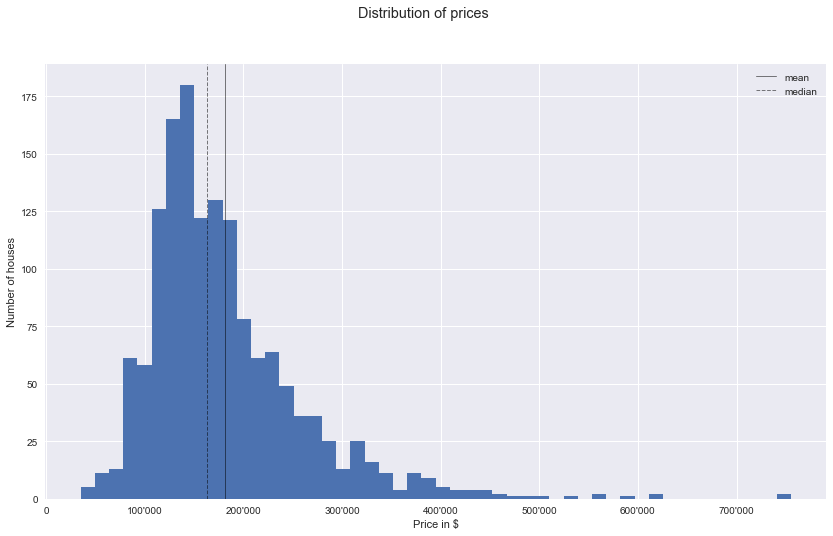

In [9]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. This gives us a much better distribution

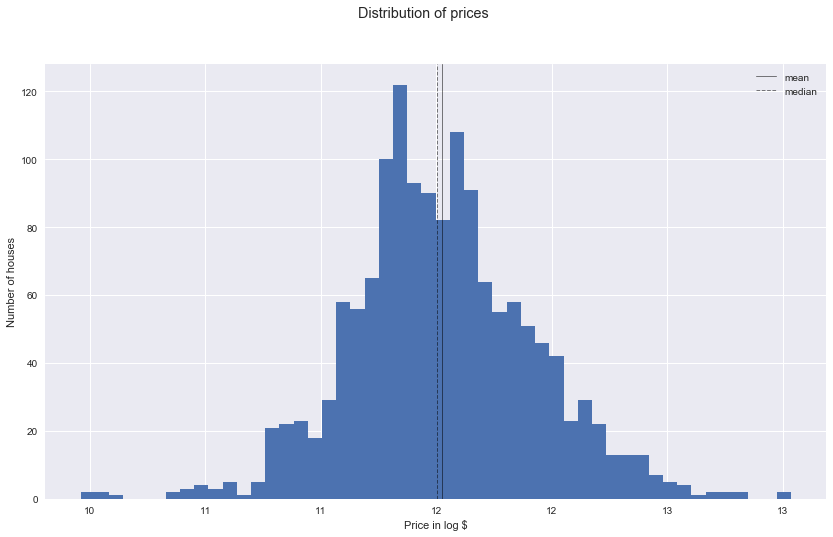

In [16]:
fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in log $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

We now have a much better distribution and we proceed like this